# Assignment 3 - Reinforcement Learning

## GridWorlds

This assignment involves finding optimal policies for two grid worlds (CliffWalking and WindyGridWorld) using SARSA and Q learning. Details about WindyGridWorld (Example 6.5) and CliffWalking (Example 6.6) can be found in the following link.
    
    http://incompleteideas.net/book/RLbook2020.pdf


You need gym (version 0.18) and numpy (version 1.20.1) for this assignment. The environment for both problems are provided. 

For Windy Grid World environemnt you also need the file 'WindyGridWorld.py'. 

### Task 1: Learning [5 Marks]

You only need to write the codes for SARSA and Q-learning algorithms. Then do the learning in both 'CliffWalking' and 'Windy Grid World' environments. 

### Task 2: Analysis [5 Marks]   

1. Calculate the average return across the episodes. It gives you a measure of the performance of the algorithm while learning.  

2. Calculate the return after convergence. It gives you a measure of the performance after the learning is completed. 

3. What do you observe from these results?

Install the necessary packages

In [1247]:
!pip install gym==0.18
!pip install numpy==1.20.1
!pip install tqdm 


# Task 1: Learning
## Task 1a: Learning in CliffWalking Environment

### Environment for CliffWalking

The board is a 4x12 matrix, with (using NumPy matrix indexing):
    [3, 0] as the start at bottom-left
    [3, 11] as the goal at bottom-right
    [3, 1..10] as the cliff at bottom-center

Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
and a reset to the start. If an action would take you off the grid, you remain in the previous state.
An episode terminates when the agent reaches the goal.


In [1248]:
%matplotlib inline

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm 

env = gym.make('CliffWalking-v0') # Create the environment #render_mode="human"  human, ansi, 
env.reset() # reset environment to a new, random state
env.render() # Renders the environment for visualization

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



Here _x_ is the location of the agent, *o* are possible places to go to, *C* is the cliff, and *T* is the target.

In [1249]:
num_actions = env.action_space.n 
num_states = env.observation_space.n 

print("Number of actions: ", num_actions)
print("Number of states: ", num_states)

Number of actions:  4
Number of states:  48


In [1250]:
action = 0 # Move up
a = env.step(action) # This is the function we use to interact with the environment
env.render() # Renders the environment for visualization

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [1251]:
# 0 -> UP, 1 -> RIGHT, 2 -> DOWN, 3 -> LEFT
env.reset()
import time
for action in [0, 1, 2, 3]:
    print("Action: ", action)
    time.sleep(1)
    next_state, reward, is_done, info = env.step(action)     # next_state, reward, is_done, info
    print("Next state: ", next_state)
    print("Reward: ", reward)
    print("Done: ",is_done)
    env.render()
env.reset()

Action:  0
Next state:  24
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action:  1
Next state:  25
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action:  2
Next state:  36
Reward:  -100
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action:  3
Next state:  36
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



36

As you can see above, each non-terminal action has a reward of -1. 0 -> UP, 1 -> RIGHT, 2 -> DOWN, 3 -> LEFT. The moment the agent falls off the cliff the reward becomes -100 and the agent resets to the start.

In [1278]:
# Initialize values 
num_episodes = 500
lr = 0.3
epsilon = 1
exploration_decreasing_decay = 0.01
min_exploration_proba = 0.1

max_steps_per_episode = 200

# Epsilon decrease code taken from https://towardsdatascience.com/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187

In [1253]:
import random
# Initialize Q function - a simplified version is used here 
# in reality the number of states may be unknown and all states may not be reachable 

# hint: use num_states as the key to a dictionary of lists
new_dict = {new_list: [0 for x in range(num_actions)] for new_list in range(num_states)}
Q = new_dict
print(Q)

{0: [0, 0, 0, 0], 1: [0, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0], 4: [0, 0, 0, 0], 5: [0, 0, 0, 0], 6: [0, 0, 0, 0], 7: [0, 0, 0, 0], 8: [0, 0, 0, 0], 9: [0, 0, 0, 0], 10: [0, 0, 0, 0], 11: [0, 0, 0, 0], 12: [0, 0, 0, 0], 13: [0, 0, 0, 0], 14: [0, 0, 0, 0], 15: [0, 0, 0, 0], 16: [0, 0, 0, 0], 17: [0, 0, 0, 0], 18: [0, 0, 0, 0], 19: [0, 0, 0, 0], 20: [0, 0, 0, 0], 21: [0, 0, 0, 0], 22: [0, 0, 0, 0], 23: [0, 0, 0, 0], 24: [0, 0, 0, 0], 25: [0, 0, 0, 0], 26: [0, 0, 0, 0], 27: [0, 0, 0, 0], 28: [0, 0, 0, 0], 29: [0, 0, 0, 0], 30: [0, 0, 0, 0], 31: [0, 0, 0, 0], 32: [0, 0, 0, 0], 33: [0, 0, 0, 0], 34: [0, 0, 0, 0], 35: [0, 0, 0, 0], 36: [0, 0, 0, 0], 37: [0, 0, 0, 0], 38: [0, 0, 0, 0], 39: [0, 0, 0, 0], 40: [0, 0, 0, 0], 41: [0, 0, 0, 0], 42: [0, 0, 0, 0], 43: [0, 0, 0, 0], 44: [0, 0, 0, 0], 45: [0, 0, 0, 0], 46: [0, 0, 0, 0], 47: [0, 0, 0, 0]}


In [1254]:
def behavioral_policy(state, Q, num_actions, epsilon):
    # Implement the epsilon-greedy policy
    # Don't forget the epsilon-greedy idea
    randomnumber= np.random.uniform(0,1)
    
    if randomnumber < epsilon:
        probs = [1/num_actions for x in range(num_actions)]
        action = np.argmax(np.random.multinomial(1, probs, size=1))
        
    else:       
        maxq=-9999999999999999999999999
        ties=[]
        
        for i in range(len(Q[state])):
            if Q[state][i]>maxq:
                maxq=Q[state][i]
                ties=[]
                
            if Q[state][i]==maxq:
                ties.append(i)
        
        action = np.random.choice(ties)

    return action 
    

In [1255]:
# You can use this to check if your algorithm is correct
for i in range(10):
    print(behavioral_policy(0, Q, num_actions, 0.8))

3
0
2
1
2
2
2
0
3
0


### Print Policy Table (Cliff) 

In [1256]:
def printpolicytablecliff(policy):
    for k,v in policy.items():
        if k==12 or k==24 or k==36:
            print()
        if v==3:
            print("LEFT", end = ' ')
        if v==2:
            print("DOWN", end = ' ')
        if v==1:
            print("RIGH", end = ' ')
        if v==0:
            print(" UP ", end = ' ')

### SARSA Learning 

In [1257]:
def sarsa(env, Q, num_actions, num_episodes, epsilon, lr):
    # Given to students
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes
    
    
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        
        # Implement SARSA
        current_action = behavioral_policy(state, Q, num_actions, epsilon)
        current_state=state
        
        while not is_done and episode_length[episode] < max_steps_per_episode:           
            next_state, reward, is_done, info = env.step(current_action) 
            next_action = behavioral_policy(next_state, Q, num_actions, epsilon)
          
            Q[current_state][current_action] = Q[current_state][current_action]  + lr*(reward + (Q[next_state][next_action]) -  Q[current_state][current_action])
            
            current_state = next_state
            current_action= next_action

            
            episode_length[episode] += 1
            total_reward_episode[episode] += reward
        
        # Reduce epsilon
        #print(epsilon)
        epsilon = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*episode))
            
            
    #create policy
    policy = {new_list2: 0 for new_list2 in range(num_states)}
    
    for state in policy.keys():
        policy[state]= np.argmax(Q[state])
    

    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}

In [1258]:
# Print Q table is freshly initialised
new_dict = {new_list: [0 for x in range(num_actions)] for new_list in range(num_states)}
Q = new_dict


# Run SARSA
optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
print("\nGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)


#Print Policy Path
print()
print("\nPolicy Graph\n")
printpolicytablecliff(sarsa_optimal_policy)

#Learned Path
print()
print("\nPost-Learning Path and Reward\n")
env.reset()
import time
time.sleep(1)
cumreward=0
next_state, reward, is_done, info = env.step(sarsa_optimal_policy[36])
cumreward+=reward
gridworld_sarsa_optimalstring=""
while not is_done:
    gridworld_sarsa_optimalstring+=f"Moving to state {next_state}, cumulative reward {cumreward}\n"
    next_state, reward, is_done, info = env.step(sarsa_optimal_policy[next_state])
    cumreward+=reward
gridworld_sarsa_optimalstring+=f"Goal 47 reached with cumulative reward of {cumreward}"
print(gridworld_sarsa_optimalstring)
env.reset()

100%|██████████████████████████████████████████| 500/500 [00:00<00:00, 580.25it/s]



GridWorld SARSA Optimal policy: 
 {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 2, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


Policy Graph

RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH DOWN 
 UP   UP   UP   UP   UP   UP  RIGH  UP   UP   UP   UP  DOWN 
 UP   UP   UP   UP   UP   UP  RIGH  UP   UP   UP  RIGH DOWN 
 UP   UP   UP   UP   UP   UP   UP   UP   UP   UP   UP   UP  

Post-Learning Path and Reward

Moving to state 24, cumulative reward -1
Moving to state 12, cumulative reward -2
Moving to state 0, cumulative reward -3
Moving to state 1, cumulative reward -4
Moving to state 2, cumulative reward -5
Moving to state 3, cumulative reward -6
Moving to state 4, cumulative reward -7
Moving to state 5, cumulative reward -8
Moving to state 6, cumul

36

### Q-Learning

In [1259]:
def q_learning(env, Q, num_actions, num_episodes, epsilon, lr):
    # Given to students
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes

   
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        # Implemnt Q-Learning
        current_state=state
        
        while not is_done and episode_length[episode] < max_steps_per_episode:
            current_action = behavioral_policy(current_state, Q, num_actions, epsilon)
            next_state, reward, is_done, info = env.step(current_action) 
            
            maxQ_of_next_state = Q[next_state][np.argmax(Q[next_state])]
            Q[current_state][current_action] = Q[current_state][current_action]  + lr*(reward + maxQ_of_next_state -  Q[current_state][current_action])

            current_state = next_state
            
            total_reward_episode[episode] += reward
            episode_length[episode] += 1

        # Reduce epsilon
        #print(epsilon)
        epsilon = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*episode))

        
    #create policy          
    policy = {new_list3: 0 for new_list3 in range(num_states)}
    
    for state in policy.keys():
        policy[state]= np.argmax(Q[state])


    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}


In [1260]:
# Print Q table is freshly initialised
new_dict = {new_list: [0 for x in range(num_actions)] for new_list in range(num_states)}
Q = new_dict

# Run Q-Learning 
optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
print("\nGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)


#Print Policy Path
print()
print("\nPolicy Graph\n")
printpolicytablecliff(q_optimal_policy)


#Learned Path
print()
print("\nPost-Learning Path and Reward\n")
env.reset()
import time
time.sleep(1)
cumreward=0
next_state, reward, is_done, info = env.step(q_optimal_policy[36])
cumreward+=reward
gridworld_qlearning_optimalstring=""
while not is_done:
    gridworld_qlearning_optimalstring+=f"Moving to state {next_state}, cumulative reward {cumreward}\n"
    next_state, reward, is_done, info = env.step(q_optimal_policy[next_state])
    cumreward+=reward
gridworld_qlearning_optimalstring+=f"Goal 47 reached with cumulative reward of {cumreward}"
print(gridworld_qlearning_optimalstring)
env.reset()

100%|██████████████████████████████████████████| 500/500 [00:00<00:00, 521.57it/s]



GridWorld Q-Learning Optimal policy: 
 {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1, 7: 2, 8: 2, 9: 1, 10: 2, 11: 2, 12: 1, 13: 1, 14: 1, 15: 2, 16: 1, 17: 2, 18: 1, 19: 1, 20: 1, 21: 2, 22: 2, 23: 2, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


Policy Graph

 UP  RIGH RIGH DOWN DOWN RIGH RIGH DOWN DOWN RIGH DOWN DOWN 
RIGH RIGH RIGH DOWN RIGH DOWN RIGH RIGH RIGH DOWN DOWN DOWN 
RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH DOWN 
 UP   UP   UP   UP   UP   UP   UP   UP   UP   UP   UP   UP  

Post-Learning Path and Reward

Moving to state 24, cumulative reward -1
Moving to state 25, cumulative reward -2
Moving to state 26, cumulative reward -3
Moving to state 27, cumulative reward -4
Moving to state 28, cumulative reward -5
Moving to state 29, cumulative reward -6
Moving to state 30, cumulative reward -7
Moving to state 31, cumulative reward -8
Moving to sta

36

In [1261]:
# run this cell if you do not have the matplotlib library
# !pip install matplotlib
import matplotlib.pyplot as plt

In [1262]:
def plot_rate(episode_length, total_reward_episode, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(episode_length)
    ax[0].set_title("Episode Length over time")
    ax[0].set(xlabel="Episode", ylabel="Length")
    ax[1].plot(total_reward_episode)
    ax[1].set_title("Episode reward over time")
    ax[1].set(xlabel="Episode reward over time", ylabel="Reward")
    fig.suptitle(title)

    plt.show()

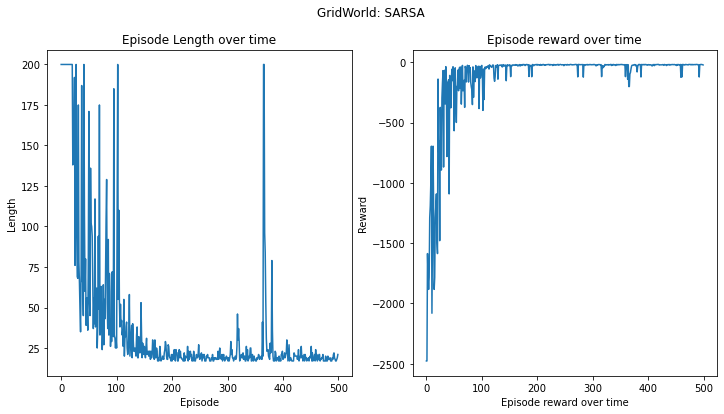

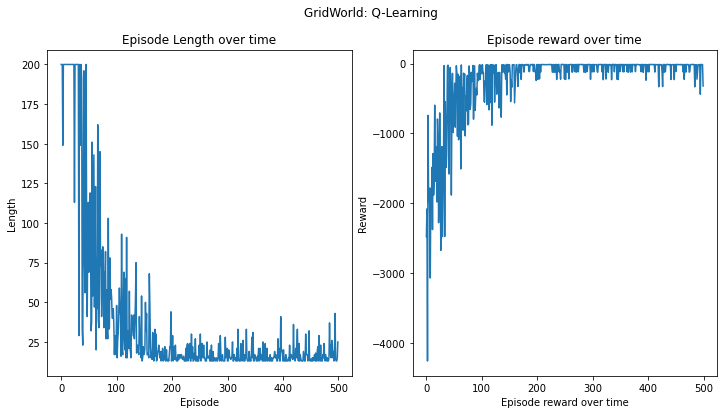

In [1263]:
plot_rate(sarsa_info["length"], sarsa_info["rewards"], "GridWorld: SARSA")
plot_rate(q_info["length"], q_info["rewards"], "GridWorld: Q-Learning")

#Copy for later analysis
gridworld_sarsa=sarsa_info.copy()
gridworld_qlearning=q_info.copy()
gridworld_sarsa_policy=sarsa_optimal_policy.copy()
gridworld_qlearning_policy=q_optimal_policy.copy()


## Task 1b: Learning in Windy Grid world

WindyGridWorld is similar to GridWorld, but with a few differences. You only need to move to the target state. But this time there is a cross-wind across the center of the grid that will push you upwards. In columns 3, 4, 5, and 8 there are winds of strength 1 while in column 6 and 7 there are winds of strength 2. For more details refer Example 6.5 in

 http://incompleteideas.net/book/RLbook2020.pdf

 You only need to change the environment and reuse the SARSA and Q-learning algorithms. 

In [1264]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP, RIGHT, DOWN, LEFT = range(4)


class WindyGridWorld(discrete.DiscreteEnv):
    def __init__(self):
        self.shape = (7, 10)
        nS = self.shape[0] * self.shape[1]
        nA = 4
        winds = np.zeros(self.shape)
        winds[:, [3,4,5, 8]] = 1
        winds[:, [6, 7]] = 2
        self.goal = (3, 7)
        # Transition probability calculation from GridWorld
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(nA)}
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)            
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)            
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)            
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
        # Starting position (3, 0)
        initial_s = np.zeros(nS)
        initial_s[np.ravel_multi_index((3,0), self.shape)] = 1.0
        super(WindyGridWorld, self).__init__(nS, nA, P, initial_s)

    def _calculate_transition_prob(self, current, move, winds):
        # Transition probability for a position landed on is 1.0, new_state calculated
        new_position = np.array(current) + np.array(move) + np.array([-1, 0]) * winds[(tuple(current))]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == self.goal
        return [(1.0, new_state, -1, is_done)]

    def _limit_coordinates(self, coord):
        for i in range(2):
            coord[i] = min(coord[i], self.shape[i] - 1)
            coord[i] = max(0, coord[i])
        return coord

    def render(self):
        outfile = sys.stdout
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            if self.s == s:
                output = " x "
            elif position == self.goal:
                output = " T "
            else:
                output = " o "
            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"
            outfile.write(output)
        outfile.write("\n")

In [1265]:
#Windy Grid World environment
env = WindyGridWorld()
env.reset()
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [1266]:
num_actions = env.action_space.n 
num_states = env.observation_space.n 

print("Number of actions: ", num_actions)
print("Number of states: ", num_states)

Number of actions:  4
Number of states:  70


Play around with different learning rates epsilons, and Q initializations to see what is best.

In [1267]:
# Initialize values 
num_episodes = 1000
lr = 0.3
epsilon = 1
exploration_decreasing_decay = 0.005
min_exploration_proba = 0.01

max_steps_per_episode = 500


In [1268]:
# Initialize Q function - a simplified version is used here 
# in reality the number of states may be unknown and all states may not be reachable 

# hint: use num_states as the key to a dictionary of lists

new_dict = {new_list: [0 for x in range(num_actions)] for new_list in range(num_states)}

Q = new_dict

### Print Policy Table (Windy) 

In [1269]:
def printpolicytablewindy(policy):
    for k,v in policy.items():
        if k==10 or k==20 or k==30 or k==40 or k==50 or k==60:
            print()
        if v==3:
            print("LEFT", end = ' ')
        if v==2:
            print("DOWN", end = ' ')
        if v==1:
            print("RIGH", end = ' ')
        if v==0:
            print(" UP ", end = ' ')

In [1270]:
new_dict = {new_list: [0 for x in range(num_actions)] for new_list in range(num_states)}
Q = new_dict


optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
print("\n WindyGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)

#Print Policy Path
print()
print("\nPolicy Graph\n")
printpolicytablewindy(sarsa_optimal_policy)


#Learned Path
print()
print("\nPost-Learning Path and Reward\n")
env.reset()
import time
time.sleep(1)
cumreward=0
next_state, reward, is_done, info = env.step(sarsa_optimal_policy[30])
cumreward+=reward
windyworld_sarsa_optimalstring=""
while not is_done:
    windyworld_sarsa_optimalstring+=f"Moving to state {next_state}, cumulative reward {cumreward}\n"
    next_state, reward, is_done, info = env.step(sarsa_optimal_policy[next_state])
    cumreward+=reward
windyworld_sarsa_optimalstring+=f"Goal 37 reached with cumulative reward of {cumreward}"
print(windyworld_sarsa_optimalstring)
env.reset()

100%|████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.16it/s]



 WindyGridWorld SARSA Optimal policy: 
 {0: 3, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 0, 11: 2, 12: 2, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1, 19: 2, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 2, 30: 1, 31: 2, 32: 2, 33: 3, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 2, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 2, 48: 3, 49: 3, 50: 1, 51: 1, 52: 0, 53: 1, 54: 1, 55: 0, 56: 0, 57: 2, 58: 1, 59: 0, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 1, 69: 0}


Policy Graph

LEFT  UP  RIGH RIGH RIGH RIGH RIGH RIGH RIGH DOWN 
 UP  DOWN DOWN RIGH RIGH RIGH RIGH DOWN RIGH DOWN 
RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH DOWN 
RIGH DOWN DOWN LEFT RIGH RIGH RIGH  UP  RIGH DOWN 
RIGH RIGH RIGH RIGH RIGH RIGH  UP  DOWN LEFT LEFT 
RIGH RIGH  UP  RIGH RIGH  UP   UP  DOWN RIGH  UP  
RIGH RIGH RIGH  UP   UP   UP   UP   UP  RIGH  UP  

Post-Learning Path and Reward

Moving to state 31, cumulative reward -1
Moving to state 41, cumulative r

30

In [1271]:
new_dict = {new_list: [0 for x in range(num_actions)] for new_list in range(num_states)}
Q = new_dict


optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
print("\n WindyGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)

#Print Policy Path
print()
print("\nPolicy Graph\n")
printpolicytablewindy(q_optimal_policy)


#Learned Path
print()
print("\nPost-Learning Path and Reward\n")
env.reset()
import time
time.sleep(1)
cumreward=0
next_state, reward, is_done, info = env.step(q_optimal_policy[36])
cumreward+=reward
windyworld_qlearning_optimalstring=""
while not is_done:
    windyworld_qlearning_optimalstring+=f"Moving to state {next_state}, cumulative reward {cumreward}\n"
    next_state, reward, is_done, info = env.step(q_optimal_policy[next_state])
    cumreward+=reward
windyworld_qlearning_optimalstring+=f"Goal 37 reached with cumulative reward of {cumreward}"
print(windyworld_qlearning_optimalstring)


100%|████████████████████████████████████████| 1000/1000 [00:02<00:00, 399.11it/s]



 WindyGridWorld Q-Learning Optimal policy: 
 {0: 3, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 2, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 2, 40: 2, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 2, 48: 3, 49: 3, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 0, 56: 0, 57: 3, 58: 3, 59: 3, 60: 1, 61: 1, 62: 2, 63: 1, 64: 0, 65: 0, 66: 0, 67: 0, 68: 2, 69: 2}


Policy Graph

LEFT RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH DOWN 
RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH DOWN 
RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH RIGH DOWN 
RIGH RIGH RIGH RIGH RIGH RIGH RIGH  UP  RIGH DOWN 
DOWN RIGH RIGH RIGH RIGH RIGH  UP  DOWN LEFT LEFT 
RIGH RIGH RIGH RIGH RIGH  UP   UP  LEFT LEFT LEFT 
RIGH RIGH DOWN RIGH  UP   UP   UP   UP  DOWN DOWN 

Post-Learning Path and Reward

Moving to state 31, cumulative reward -1
Moving to state 32, cumulat

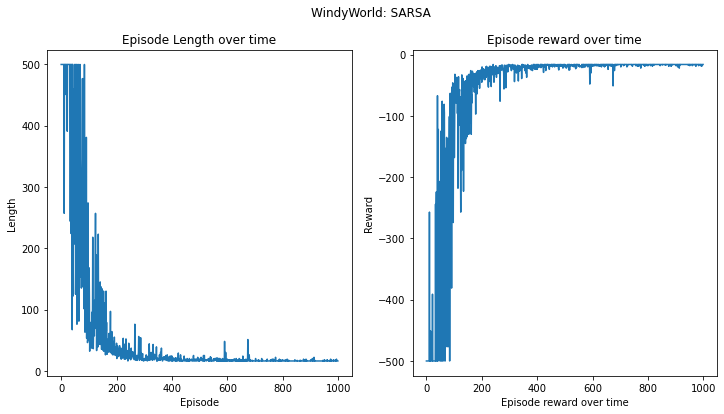

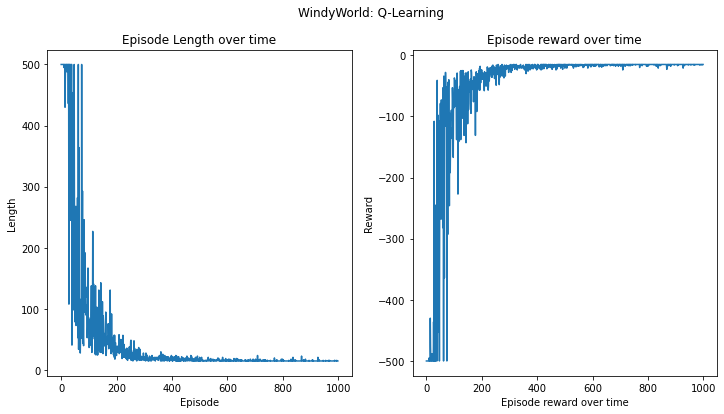

In [1272]:
plot_rate(sarsa_info["length"], sarsa_info["rewards"], "WindyWorld: SARSA")
plot_rate(q_info["length"], q_info["rewards"], "WindyWorld: Q-Learning")

#Copy for later analysis
windyworld_sarsa=sarsa_info.copy()
windyworld_qlearning=q_info.copy()
windyworld_sarsa_policy=sarsa_optimal_policy.copy()
windyworld_qlearning_policy=q_optimal_policy.copy()


# Task 2: Analysis (Comparison of Q-learning and SARSA learning algorithms)

1. Comment on the number of episodes required to converge to the optimal policy for both environments. 
       
2. Discuss the differences in the reward graphs.  

3. Calculate the average return across the episodes for each environment. It gives a measure of the performance of the algorithm while learning (i.e., online performance).  

4. Calculate the return after convergence. It gives you a measure of the performance after the learning is completed (i.e., offline performance). 

5. Briefly summarize your results.
 
 It is advisable to rerun the algorithm a few times to get a clearer understanding of the algorithms.

## 1. Comment on the number of episodes required to converge to the optimal policy for both environments. 

To make the graphs easier to see, we smoothed the values over 30 episodes in the code snippet below. Please refer to the 2 graphs below this code snippet. 


### A. Cliff Walking
Both Sarsa and Q-Learning converges to their respective policies after 180 episodes, from the graphs below in 1 and 2. We started with an epsilon of 1 and tapered this down with each Episode. 

However, it is important to note that they both converge to different policies. From the policy plot above, Sarsa takes the safer path all the way at the top to move to the right, while Q-Learning hugs the cliff on the third row of the grid to move to the right (which is the actual Optimal Policy that maximizes rewards). 

Hence, Sarsa takes about 150 episodes to get to an average of 18 in Episode Length (as it is taking a slightly longer route) for its policy (less optimal), while Q-Learning takes the same 150 episodes to get to an average of 15 in Episode Length for its policy (its curve is below that of Sarsa).  



### B. Windy GridWorld
Both Sarsa and Q-Learning converges to their respective policies after approximately 380 environments. Both performed quite similarly, with an almost identical curve downwards. Q-Learning was marginally faster initially, but there was no significant difference. 


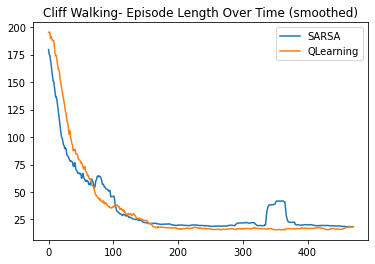

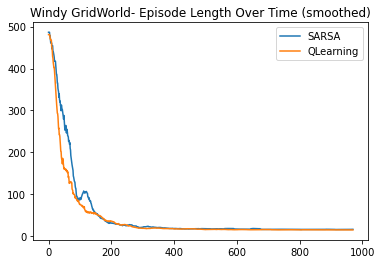

In [1273]:
# Moving average code taken from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
# Plot code taken from https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Cliff Walking- Creating a smoothed line over 30 episodes
gridworld_sarsa_smoothed_epilength=[]
gridworld_sarsa_smoothed_epilength= moving_average(gridworld_sarsa["length"], 30)

gridworld_qlearning_smoothed_epilength=[]
gridworld_qlearning_smoothed_epilength= moving_average(gridworld_qlearning["length"], 30)

plt.plot(gridworld_sarsa_smoothed_epilength, label = "SARSA")
plt.plot(gridworld_qlearning_smoothed_epilength, label = "QLearning")
plt.legend()
plt.title("Cliff Walking- Episode Length Over Time (smoothed)")
plt.show()


# Windy GridWorld- Creating a smoothed line over 30 episodes
windyworld_sarsa_smoothed_epilength=[]
windyworld_sarsa_smoothed_epilength= moving_average(windyworld_sarsa["length"], 30)

windyworld_qlearning_smoothed_epilength=[]
windyworld_qlearning_smoothed_epilength= moving_average(windyworld_qlearning["length"], 30)

plt.plot(windyworld_sarsa_smoothed_epilength, label = "SARSA")
plt.plot(windyworld_qlearning_smoothed_epilength, label = "QLearning")
plt.legend()
plt.title("Windy GridWorld- Episode Length Over Time (smoothed)")
plt.show()


## 2. Discuss the differences in the reward graphs.

To make the graphs easier to see, we smoothed the values over 25 episodes in the code snippet below. For the reward graphs, we hid values less than -200 in Cliff Walking, and values less than -80 for Windy GridWorld. This tends to happen at the start where the agent is exploring the environment.

Please refer to the 2 graphs below this code snippet. 



### A. Cliff Walking
From the graph below, Q-Learning has a lower average episode reward after convergence (approx -50), than Sarsa, which hovers around -25. 

As mentioned above, Sarsa converges to a path at the top, which is the safer path, while Q-Learning finds the optimal policy on the third row which hugs the cliff.

This means that while Q-Learning learns the optimal policy and aims for the shortest episode length (quickest route), it has a chance of falling into the cliff when exploring (eg, in the top part of Epsilon Greedy policy), getting an immediate -100 and having to start over, sometimes more than once. Hence, its line is almost always below Sarsa throughout the smoothed graph.

In the unsmoothed graph at the top of the report, we can observe the heavy variance difference in Q-Learning and Sarsa, with sharp drops happening when it falls into the cliff and tries again (sometimes more than once), giving rewards of well below -100 to -200 in those episodes.  

While Sarsa tries for a longer and non-optimal path, it does not bear this heavy a risk of falling into the cliff, hence its average rewards tend to be higher, with lower variance.



### B. Windy GridWorld

Both Sarsa and Q-Learning seemed to perform very similarly after converging. Q-Learning performed marginally better, but only by 1-2 points. Q-Learning also took a marginally faster path down to convergence, with its graph seen as below the line of Sarsa initially. 


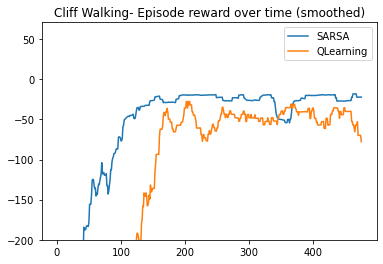

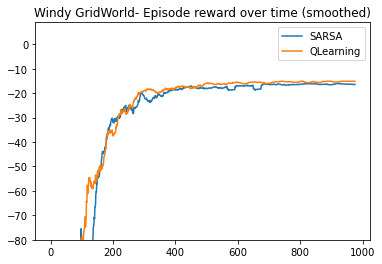

In [1274]:
# Cliff Walking- Creating a smoothed line over 25 episodes
gridworld_sarsa_smoothed_rewards=[]
gridworld_sarsa_smoothed_rewards= moving_average(gridworld_sarsa["rewards"], 25)

gridworld_qlearning_smoothed_rewards=[]
gridworld_qlearning_smoothed_rewards= moving_average(gridworld_qlearning["rewards"], 25)

plt.plot(gridworld_sarsa_smoothed_rewards, label = "SARSA")
plt.plot(gridworld_qlearning_smoothed_rewards, label = "QLearning")
plt.legend()
plt.title("Cliff Walking- Episode reward over time (smoothed)")
plt.ylim((-200))
plt.show()


# Windy GridWorld- Creating a smoothed line over 25 episodes
windyworld_sarsa_smoothed_rewards=[]
windyworld_sarsa_smoothed_rewards= moving_average(windyworld_sarsa["rewards"], 25)

windyworld_qlearning_smoothed_rewards=[]
windyworld_qlearning_smoothed_rewards= moving_average(windyworld_qlearning["rewards"], 25)

plt.plot(windyworld_sarsa_smoothed_rewards, label = "SARSA")
plt.plot(windyworld_qlearning_smoothed_rewards, label = "QLearning")
plt.legend()
plt.title("Windy GridWorld- Episode reward over time (smoothed)")
plt.ylim((-80))
plt.show()

## 3. Calculate the average return across the episodes for each environment. It gives a measure of the performance of the algorithm while learning (i.e., online performance).  

### A. Cliff Walking

As calculated below, the average return for Sarsa during the entire duration of learning is -122.998, while the average return for Sarsa during the last 50 iteration is -24.76.

For Q-Learning, the average return during the entire duration of learning is -246.704, while the average return for Sarsa during the last 50 iteration is -58.86. 

This is consistent with what we saw above, where Q-Learning has a lower average return when learning due to it falling off the cliff in some episodes. 


### B. Windy GridWorld
As calculated below, the average return for Sarsa during the entire duration of learning is -56.217, while the average return for Sarsa during the last 100 iteration is -16.34.

For Q-Learning, the average return during the entire duration of learning is -48.589, while the average return for Sarsa during the last 100 iteration is -15.19. 

This is consistent with what we saw above, where Q-Learning has a very slightly higher average return when learning. Both Sarsa and Q-Learning eventually took the same path, going right initially, being pushed up by the wind, further right, down, and left to reach the goal state. 


In [1275]:
def averagereturn(iterations,steps,array):
    for i in range(iterations):
        print((i+1)*steps,": mean espiode reward: ", np.mean(array[steps*i:steps*(i+1)]))


# Average Return- Cliff Walking- SARSA (ie, 0 to 50, 51-100, etc)
print("Average Return, Cliff Walking- SARSA, across every 50 episodes, for 500 episodes:")
averagereturn(10,50,gridworld_sarsa["rewards"])
print()

print("Average Return, Cliff Walking- SARSA, across all 500 episodes")
print(np.mean(gridworld_sarsa["rewards"]))
print()


# Average Return- Cliff Walking- Q-Learning
print("Average Return, Cliff Walking- Q-Learning, across every 50 episodes, for 500 episodes:")
averagereturn(10,50,gridworld_qlearning["rewards"])
print()

print("Average Return, Cliff Walking- Q-Learning, across all 500 episodes")
print(np.mean(gridworld_qlearning["rewards"]))
print()

print()
print()

# Average Return- Windy GridWorld- SARSA (ie, 0 to 100, 101-200, etc)
print("Average Return, Windy GridWorld- SARSA, across every 100 episodes, for 1000 episodes:")
averagereturn(10,100,windyworld_sarsa["rewards"])
print()

print("Average Return, Windy GridWorld- SARSA, across all 1000 episodes")
print(np.mean(windyworld_sarsa["rewards"]))
print()


# Average Return- Windy GridWorld- Q-Learning
print("Average Return, Windy GridWorld- Q-Learning, across every 100 episodes, for 1000 episodes:")
averagereturn(10,100,windyworld_qlearning["rewards"])
print()

print("Average Return, Windy GridWorld- Q-Learning, across all 1000 episodes")
print(np.mean(windyworld_qlearning["rewards"]))
print()

          

Average Return, Cliff Walking- SARSA, across every 50 episodes, for 500 episodes:
50 : mean espiode reward:  -849.0
100 : mean espiode reward:  -148.38
150 : mean espiode reward:  -56.14
200 : mean espiode reward:  -27.62
250 : mean espiode reward:  -19.82
300 : mean espiode reward:  -22.94
350 : mean espiode reward:  -23.04
400 : mean espiode reward:  -38.54
450 : mean espiode reward:  -19.74
500 : mean espiode reward:  -24.76

Average Return, Cliff Walking- SARSA, across all 500 episodes
-122.998

Average Return, Cliff Walking- Q-Learning, across every 50 episodes, for 500 episodes:
50 : mean espiode reward:  -1443.8
100 : mean espiode reward:  -410.14
150 : mean espiode reward:  -220.08
200 : mean espiode reward:  -92.76
250 : mean espiode reward:  -52.38
300 : mean espiode reward:  -52.12
350 : mean espiode reward:  -50.34
400 : mean espiode reward:  -40.18
450 : mean espiode reward:  -46.38
500 : mean espiode reward:  -58.86

Average Return, Cliff Walking- Q-Learning, across all 5

## 4. Calculate the return after convergence. It gives you a measure of the performance after the learning is completed (i.e., offline performance). 

### A. Cliff Walking
As calculated below, the return for Sarsa after convergence is -17, while the return for Q-Learning is -13.

As discussed, Sarsa has learnt the longer route at the top, while Q-Learning has found the actual optimal policy on the third row to get from left to right. Differences in results are discussed in Part 5 below. 


### B. Windy GridWorld

As calculated below, the average return for Sarsa after convergence is -16, while the average return for Q-Learning is -15.

As discussed, both Sarsa and Q-Learning eventually found almost identical policies which are the optimal policy (-15) or very close to the optimal policy (-16 or -17), taking the route to the right, up to the top row, to the extreme right, down to the fifth row, and left to the goal. Differences in results are discussed in Part 5 below. 


In [1276]:
# Windy GridWorld Return After Convergence
print("Cliff Walking Return After Convergence (Sarsa)")
print(gridworld_sarsa_optimalstring)
print()
print("Cliff Walking Return After Convergence (Q-Learning)")
print(gridworld_qlearning_optimalstring)
print()
print()
# Windy GridWorld Return After Convergence
print("Windy GridWorld Return After Convergence (Sarsa)")
print(windyworld_sarsa_optimalstring)
print()
print("Windy GridWorld Return After Convergence (Q-Learning)")
print(windyworld_qlearning_optimalstring)

Cliff Walking Return After Convergence (Sarsa)
Moving to state 24, cumulative reward -1
Moving to state 12, cumulative reward -2
Moving to state 0, cumulative reward -3
Moving to state 1, cumulative reward -4
Moving to state 2, cumulative reward -5
Moving to state 3, cumulative reward -6
Moving to state 4, cumulative reward -7
Moving to state 5, cumulative reward -8
Moving to state 6, cumulative reward -9
Moving to state 7, cumulative reward -10
Moving to state 8, cumulative reward -11
Moving to state 9, cumulative reward -12
Moving to state 10, cumulative reward -13
Moving to state 11, cumulative reward -14
Moving to state 23, cumulative reward -15
Moving to state 35, cumulative reward -16
Goal 47 reached with cumulative reward of -17

Cliff Walking Return After Convergence (Q-Learning)
Moving to state 24, cumulative reward -1
Moving to state 25, cumulative reward -2
Moving to state 26, cumulative reward -3
Moving to state 27, cumulative reward -4
Moving to state 28, cumulative reward

## 5. Briefly summarize your results.

### Difference in Sarsa and Q-Learning (Risky vs Non-Risky Scenarios)
a) For Cliff Walking, Sarsa outperforms Q-Learning during the learning process (reward of -122.998 vs -246.704 respectively, or -24.76 vs -58.86 in the last 50 episodes), however, after learning, Q-Learning found the optimal policy and the path with the highest reward (-13), versus Sarsa which found the safer path (-17).

b) This illustrates an important point, if we are trying to quickly iterate and learn in a space where mistakes are costly like in the case of the cliff which has a -100 penalty, then Sarsa would find a more conservative approach during the learning process. For example, a scenario where self driving cars which can hit someone while it is still training, and a car could be very expensive to fix, could be an example of costly risk during learning. 

c) This is because for Sarsa, it is sensitive to the chances that could occur for tiles closer to the cliff (following Epsilon Greedy), while Q-Learning would just update the maximum Q values and head for the optimal route.   

d) Hence, we should prefer Sarsa in such an environment.

e) However, even in this scenario, Q-Learning would still outperform in the end after learning is complete, with a lower reward. This assumes that post-learning, our environment would still be fully deterministic. If not, taking the risker path this close to the cliff may still be dangerous, and may not be optimal.  


f) However, if we would like to iterate fast in environments which do not have severe costs or risk penalties, then Q-Learning presents a faster and better choice for us, both during learning and post-learning. 

g) We can see this in the Windy GridWorld example, which does not have severe penalties during learning. The agent does not get hit with a dramatic negative reward, nor are there tiles where it needs to return all the way to the start. 

h) In this scenario, Q-Learning outperforms slightly during the learning (reward of -48.589 vs -56.217 for Q-Learning and Sarsa respectively), and also outperforms post-learning (reward of -15 vs -16 respectively). It gets to the optimal policy slightly quicker than Sarsa as well. 

i) Hence, we could prefer Q-Learning in such an environment, as it would give us better rewards during learning (ie, no major risks or heavy cost of mistakes), while also giving us the optimal path post-learning, instead of the safe path.

j) For example, if we are training a robot entirely in a simulation, and not the real world, there would not be any drastic penalties involve of taking a bad paths. 





### Learning Rate, Epsilon and Initial Q-Values Selection

#### Learning Rate 
The team ran various iterations of Learning Rates using the above code, and have the following results. 

On balance, the team selecting a LR of 0.3 for both scenarios. 

For Cliff Walking, all LRs gave the same path post-learning. LRs of 0.6 and 0.1 took slightly more time to converge in some runs, and less time in other runs, though the differences is neglibible.

For Windy GridWorld, a LR of 0.6 took slightly longer to converge in some runs, and slightly quicker in other runs, with a slightly less optimal policy given for Sarsa. 0.1 took longer to converge in both cases, though it did give a slightly better policy for Sarsa. 


Cliff Walking- Sarsa
- Current LR (0.3)- Average Reward during Learning (-122.998)- Average Reward After Learning (-17)
- Experiment LR (0.6)- Average Reward during Learning (-166.854)- Average Reward After Learning (-17)
- Experiment LR (0.1)- Average Reward during Learning (-120.216)- Average Reward After Learning (-17)

Cliff Walking- Q-Learning
- Current LR (0.3)- Average Reward during Learning (-246.704)- Average Reward After Learning (-13)
- Experiment LR (0.6)- Average Reward during Learning (-245.626)- Average Reward After Learning (-13)
- Experiment LR (0.1)- Average Reward during Learning (-254.532)- Average Reward After Learning (-13)


Windy GridWorld- Sarsa
- Current LR (0.3)- Average Reward during Learning (-56.217)- Average Reward After Learning (-16)
- Experiment LR (0.6)- Average Reward during Learning (-62.497)- Average Reward After Learning (-17)
- Experiment LR (0.1)- Average Reward during Learning (-67.486)- Average Reward After Learning (-15)

Windy GridWorld- Q-Learning
- Current LR (0.3)- Average Reward during Learning (-48.589)- Average Reward After Learning (-15)
- Experiment LR (0.6)- Average Reward during Learning (-45.48)- Average Reward After Learning (-15)
- Experiment LR (0.1)- Average Reward during Learning (-57.653)- Average Reward After Learning (-15)


#### Epsilon
The team experimented with various Epsilon values, from 0.01, to 0.1 and 0.3. Eventually, the team decided to start Epsilon with 1 and reduce this gradually for a better result. 

For Cliff Walking, this started at 1, and reduced until it hit 0.1. For Windy GridWorld, the optimum value was by starting at 1, and ending at 0.01 so both Sarsa and Q-Learning could start exploiting aggressively towards the end.


#### Initial Q-Values

The team tried several potential Q-Values, comparing the results and also the graphs, there was no significant difference for the values tried. On balance, the team decided to start with all 0 for the Q-Values. 


Cliff Walking- Sarsa
- Current Q-Values (All 0)- Average Reward during Learning (-122.998)- Average Reward After Learning (-17)
- Experiment Q-Values (All -5)- Average Reward during Learning (-130.474)- Average Reward After Learning (-17)
- Experiment Q-Values (All -500)- Average Reward during Learning (-120.064)- Average Reward After Learning (-17)


Cliff Walking- Q-Learning
- Current Q-Values (All 0)- Average Reward during Learning (-246.704)- Average Reward After Learning (-13)
- Experiment Q-Values (All -5)- Average Reward during Learning (-257.554)- Average Reward After Learning (-13)
- Experiment Q-Values (All -500)- Average Reward during Learning (-225.994)- Average Reward After Learning (-13)


Windy GridWorld- Sarsa
- Current Q-Values (All 0)- Average Reward during Learning (-56.217)- Average Reward After Learning (-16)
- Experiment Q-Values (All -5)- Average Reward during Learning (-59.77)- Average Reward After Learning (-16)
- Experiment Q-Values (All -500)- Average Reward during Learning (-58.504)- Average Reward After Learning (-16)

Windy GridWorld- Q-Learning
- Current Q-Values (All 0)- Average Reward during Learning (-48.589)- Average Reward After Learning (-15)
- Experiment Q-Values (All -5)- Average Reward during Learning (-47.935)- Average Reward After Learning (-15)
- Experiment Q-Values (All -500)- Average Reward during Learning (-46.059)- Average Reward After Learning (-15)
